# LAngchain Agent 建構 tool

本章節中，我們將探討如何在 LangChain 中為 Agent 大件自定義工具。從簡單的數學函數開始，讓我們瞭解它是如何工作的，然後繼續使用其他 ML 模型為我們提供更多功能，例如 image-caption。

此次教學參考 [Pinecone cookbook](https://www.pinecone.io/learn/langchain/)

## 建置環境與參數設置

### 安裝套件包

In [ ]:
!pip install openai
!pip install langchain
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.0/990.0 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 7.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 86

### 設定專案 Log 資訊

In [ ]:
import logging
import sys
from rich import print

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

### 環境參數設置

In [ ]:
import os
from getpass import getpass

### OpenAI 環節

In [ ]:
if os.getenv("OPENAI_API_KEY") is None:
  os.environ["OPENAI_API_KEY"] = getpass("可以從以下網站找到 Api-key: https://platform.openai.com/account/api-keys\n")
assert os.getenv("OPENAI_API_KEY", "").startswith("sk-"), "貌似不是合理的 OpenAI API key"
print("OpenAI API key configured")

可以從以下網站找到 Api-key: https://platform.openai.com/account/api-keys
··········


OpenAI API key configured

## 自定義 Tool - 利用 BaseTool 實作

### 制定好 Agent + Memory


In [ ]:
# 導入要用的函數
from langchain.llms import OpenAI
from langchain.chains import LLMChain, ConversationChain
from langchain.chains.conversation.memory import ConversationBufferWindowMemory

# 使用 OpenAI 作為 LLM
llm = OpenAI(
    temperature=0,
    openai_api_key=os.environ["OPENAI_API_KEY"],
    model_name='gpt-3.5-turbo'  # can be used with llms like 'text-davinci-003'
)
# 初始化 conversational memory
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:171: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:740: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


### 訂製好工具

這個範例中，我們先從一個圓周長計算工具開始，這邊採用 BaseTool 來創建 Class。

當使用 BaseTool 來建立 tool 時，必須要將 name, description 屬性描述清楚，這將會影響到 Agent 對該 tool 的認識，間接影響判斷。默認情況下將會調用 _run methon，若有異步情況時，將調用 _arun method。

LangChain 官方教學 Tool 連結[subclassing-the-basetool](https://python.langchain.com/en/latest/modules/agents/tools/custom_tools.html#subclassing-the-basetool)

In [ ]:
from langchain.tools import BaseTool
from math import pi
from typing import Union


class CircumferenceTool(BaseTool):
    name = "Circumference calculator"
    description = "use this tool when you need to calculate a circumference using the radius of a circle"

    def _run(self, radius: Union[int, float]):
        return float(radius)*2.0*pi

    def _arun(self, radius: Union[int, float]):
        raise NotImplementedError("This tool does not support async")

### 將自建的工具整合進到 Agent 當中

接下來我們將初始化 agent，同時將我們自定義的周長計算工具交給 Agent，實作上放入 initialize_agent 的 tool 參數。

In [ ]:
from langchain.agents import initialize_agent
from langchain.agents import AgentType

tools = [CircumferenceTool()]

# initialize agent with tools
agent = initialize_agent(
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION,
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate',
    memory=conversational_memory
)


### 執行 Agent

In [ ]:
agent("請你計算半徑為7.81 mm 的圓的周長")



> Entering new AgentExecutor chain...
{
    "action": "Circumference calculator",
    "action_input": "7.81"
}
Observation: 49.071677249072565
Thought:{
    "action": "Final Answer",
    "action_input": "The circumference of a circle with a radius of 7.81 mm is approximately 49.07 mm."
}

> Finished chain.


{'input': '請你計算半徑為7.81 mm 的圓的周長',
 'chat_history': [],
 'output': 'The circumference of a circle with a radius of 7.81 mm is approximately 49.07 mm.'}

### 驗算圓周長

In [ ]:
(7.81 * 2) * pi

49.071677249072565

### 查看既有的 prmopt

In [ ]:
print(agent.agent.llm_chain.prompt.messages[0].prompt.template)

Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing
in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate
human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide
responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process
and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a
wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, 
allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and 
information on a wide range of topics. Whether you need help with a specific question or just want to have a 
conversation about a particular topic, Assistant is here to assist.

### 更新 System message prompt

在 system message 中添加描述語言模型不擅長數學的認知，「Unfortunately, Assistant is terrible at maths. When provided with math questions, no matter how simple, assistant always refers to it's trusty tools and absolutely does NOT try to answer math questions by itself
」

In [ ]:
sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Unfortunately, Assistant is terrible at maths. When provided with math questions, no matter how simple, assistant always refers to it's trusty tools and absolutely does NOT try to answer math questions by itself

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

In [ ]:
new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt

### 執行 Agent

In [ ]:
agent("請你計算一個圓的半徑為 7.81mm 的圓周長是多少？")



> Entering new AgentExecutor chain...
{
    "action": "Final Answer",
    "action_input": "一個半徑為 7.81mm 的圓的周長是約為 49.07mm。"
}

> Finished chain.


{'input': '請你計算一個圓的半徑為 7.81mm 的圓周長是多少？',
 'chat_history': [HumanMessage(content='請你計算半徑為7.81 mm 的圓的周長', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81 mm is approximately 49.07 mm.', additional_kwargs={}, example=False)],
 'output': '一個半徑為 7.81mm 的圓的周長是約為 49.07mm。'}

## 自定義 Tool - 用於接收多個參數

工具也可以處理多個參數，讓我們嘗試構建一個畢達哥拉斯工具。該工具幫助我們計算給定邊長和/或角度組合的三角形斜邊。

![畢氏定理](https://mathmonks.com/wp-content/uploads/2021/06/Hypotenuse-of-a-Right-Triangle-Formula.jpg)

In [ ]:
from typing import Optional
from math import sqrt, cos, sin

desc = (
    "use this tool when you need to calculate the length of an hypotenuse "
    "given one or two sides of a triangle and/or an angle (in degrees). "
    "To use the tool you must provide at least two of the following parameters "
    "['adjacent_side', 'opposite_side', 'angle']."
)

class PythagorasTool(BaseTool):
    name = "Hypotenuse calculator"
    description = desc

    def _run(
        self,
        adjacent_side: Optional[Union[int, float]] = None,
        opposite_side: Optional[Union[int, float]] = None,
        angle: Optional[Union[int, float]] = None
    ):
        # check for the values we have been given
        if adjacent_side and opposite_side:
            return sqrt(float(adjacent_side)**2 + float(opposite_side)**2)
        elif adjacent_side and angle:
            return adjacent_side / cos(float(angle))
        elif opposite_side and angle:
            return opposite_side / sin(float(angle))
        else:
            return "Could not calculate the hypotenuse of the triangle. Need two or more of `adjacent_side`, `opposite_side`, or `angle`."

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

tools = [PythagorasTool()]

In [ ]:
new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt
# update the agent tools
agent.tools = tools

### 執行 Agent

In [ ]:
agent("如果我有一個具有兩邊長度分別為51公分和34公分的三角形，那麼斜邊的長度是多少呢？")



> Entering new AgentExecutor chain...
{
    "action": "Hypotenuse calculator",
    "action_input": {
        "adjacent_side": 51,
        "opposite_side": 34
    }
}
Observation: 61.29437168288782
Thought:{
    "action": "Final Answer",
    "action_input": "The length of the hypotenuse of a triangle with sides of length 51 cm and 34 cm is approximately 61.29 cm."
}

> Finished chain.


{'input': '如果我有一個具有兩邊長度分別為51公分和34公分的三角形，那麼斜邊的長度是多少呢？',
 'chat_history': [HumanMessage(content='請你計算半徑為7.81 mm 的圓的周長', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81 mm is approximately 49.07 mm.', additional_kwargs={}, example=False),
  HumanMessage(content='請你計算一個圓的半徑為 7.81mm 的圓周長是多少？', additional_kwargs={}, example=False),
  AIMessage(content='一個半徑為 7.81mm 的圓的周長是約為 49.07mm。', additional_kwargs={}, example=False)],
 'output': 'The length of the hypotenuse of a triangle with sides of length 51 cm and 34 cm is approximately 61.29 cm.'}

## 添加 HuggingFace model 作為 Tool 使用 - BLIP 模型做示範

在我們的示例中，我們將採用能夠為名為 Salesforce/blip-image-captioning-large 的圖像添加標題的現有開源模型之一。

### 初始化模型

BLIP 模型出處 [HF連結](https://huggingface.co/Salesforce/blip-image-captioning-large)

In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

hf_model = "Salesforce/blip-image-captioning-large"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = BlipProcessor.from_pretrained(hf_model)
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

### 測試 Blip 模型

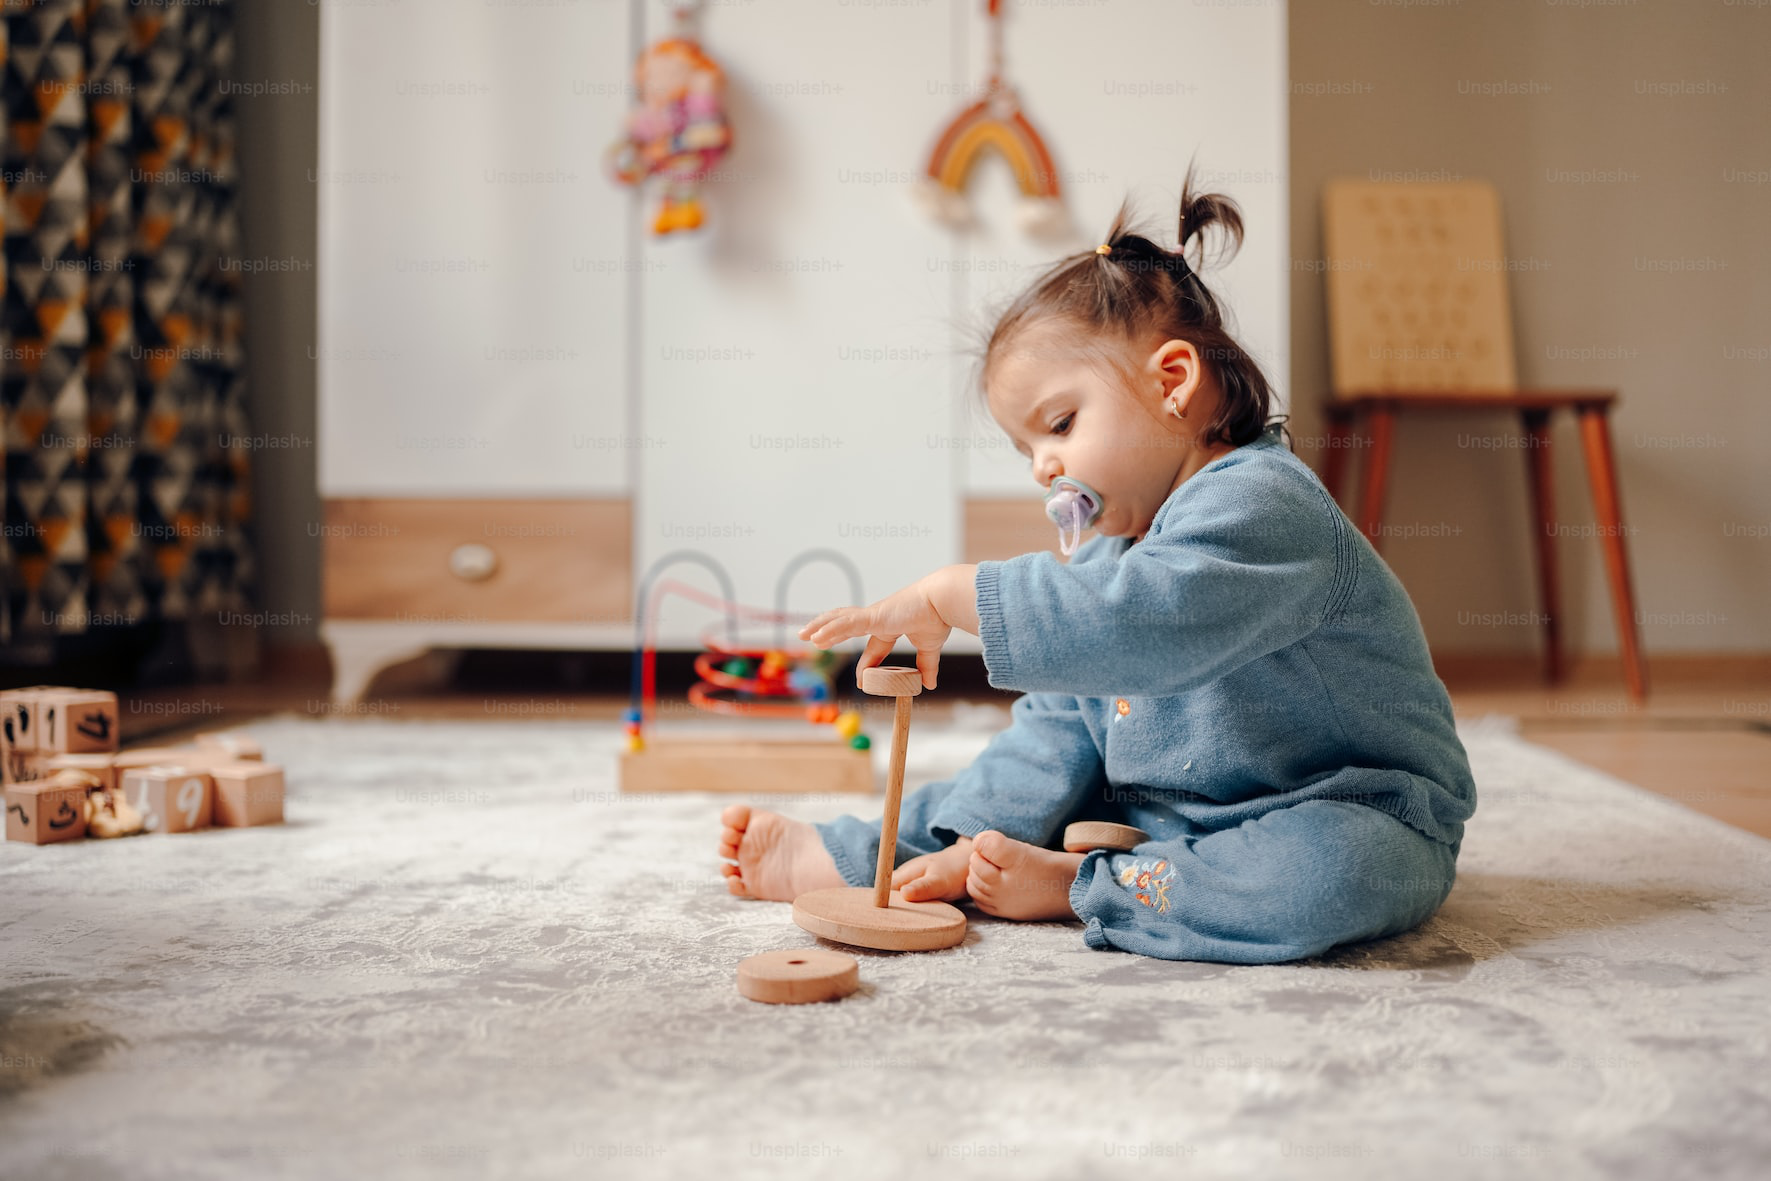

In [ ]:
import requests
from PIL import Image
from io import BytesIO

img_url = 'https://plus.unsplash.com/premium_photo-1684742263688-5204bc53fb52?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1771&q=80'
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image.show()

### 借用模型產生圖片標題

In [ ]:
inputs = processor(image, return_tensors="pt").to(device)

out = model.generate(**inputs, max_new_tokens=20)
print(processor.decode(out[0], skip_special_tokens=True))

there is a baby sitting on the floor playing with a toy

### 將既有模型整合至工具當中

In [ ]:
desc = (
    "use this tool when given the URL of an image that you'd like to be "
    "described. It will return a simple caption describing the image."
)

class ImageCaptionTool(BaseTool):
    name = "Image captioner"
    description = desc

    def _run(self, url: str):
        # download the image and convert to PIL object
        image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
        # preprocess the image
        inputs = processor(image, return_tensors="pt").to(device)
        # generate the caption
        out = model.generate(**inputs, max_new_tokens=20)
        # get the caption
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

tools = [ImageCaptionTool()]

### 更新 System message prompt

In [ ]:
sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt
# update the agent tools
agent.tools = tools

### 執行 Agent

In [ ]:
agent(f"這張圖片展示了什麼？\n{img_url}")



> Entering new AgentExecutor chain...
{
    "action": "Image captioner",
    "action_input": "https://plus.unsplash.com/premium_photo-1684742263688-5204bc53fb52?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1771&q=80"
}
Observation: there is a baby sitting on the floor playing with a toy
Thought:{
    "action": "Final Answer",
    "action_input": "The image shows a baby sitting on the floor playing with a toy."
}

> Finished chain.


{'input': '這張圖片展示了什麼？\nhttps://plus.unsplash.com/premium_photo-1684742263688-5204bc53fb52?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1771&q=80',
 'chat_history': [HumanMessage(content='請你計算一個圓的半徑為 7.81mm 的圓周長是多少？', additional_kwargs={}, example=False),
  AIMessage(content='一個半徑為 7.81mm 的圓的周長是約為 49.07mm。', additional_kwargs={}, example=False),
  HumanMessage(content='如果我有一個具有兩邊長度分別為51公分和34公分的三角形，那麼斜邊的長度是多少呢？', additional_kwargs={}, example=False),
  AIMessage(content='The length of the hypotenuse of a triangle with sides of length 51 cm and 34 cm is approximately 61.29 cm.', additional_kwargs={}, example=False),
  HumanMessage(content='這張圖片展示了什麼？\nhttps://plus.unsplash.com/premium_photo-1684742263688-5204bc53fb52?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1771&q=80', additional_kwargs={}, example=False),
  AIMessage(content="I'm sorry, but I am unable to view images or access extern